In [29]:
# Import necessary libraries
import numpy as np
from scipy import io
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import color
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initialize general variables
train_num = 50000
valid_num = 20000
test_num = 25000
width = 32
height = 32
num_channels = 1
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [30]:
# Load small training and testing data and labels into memory
train_mat = io.loadmat('svhn_small/train_32x32.mat')
test_mat = io.loadmat('svhn_small/test_32x32.mat')

train_X = np.rollaxis(train_mat['X'][:,:,:,:train_num], 3)
train_y = train_mat['y'][:train_num,:]
valid_X = np.rollaxis(train_mat['X'][:,:,:,train_num:train_num + valid_num], 3)
valid_y = train_mat['y'][train_num:train_num + valid_num,:]
test_X = np.rollaxis(test_mat['X'][:,:,:,:test_num], 3)
test_y = test_mat['y'][:test_num,:]

# Convert images to grayscale
train_X_gray = np.ndarray((train_num, width, height))
valid_X_gray = np.ndarray((valid_num, width, height))
test_X_gray = np.ndarray((test_num, width, height))

for i in xrange(train_num):
    train_X_gray[i,:,:] = color.rgb2gray(train_X[i,:,:,:])

for i in xrange(valid_num):
    valid_X_gray[i,:,:] = color.rgb2gray(valid_X[i,:,:,:])
    
for i in xrange(test_num):
    test_X_gray[i,:,:] = color.rgb2gray(test_X[i,:,:,:])
    
print 'Training: grayscale data shape = ' + str(train_X_gray.shape) + ', label shape = ' +  str(train_y.shape)
print 'Validation: grayscale data shape = ' + str(valid_X_gray.shape) + ', label shape = ' +  str(valid_y.shape)
print 'Testing: grayscale data shape = ' + str(test_X_gray.shape) + ', label shape = ' +  str(test_y.shape)

Training: grayscale data shape = (50000, 32, 32), label shape = (50000, 1)
Validation: grayscale data shape = (20000, 32, 32), label shape = (20000, 1)
Testing: grayscale data shape = (25000, 32, 32), label shape = (25000, 1)


[1, 9, 2, 3, 2]


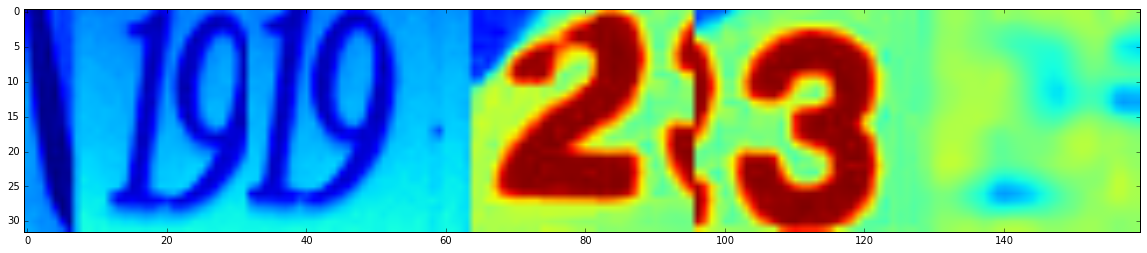

In [31]:
# Let's look at a couple images
print [x[0] for x in train_y[:5]]

zero = train_X_gray[0,:,:]
one = train_X_gray[1,:,:]
two = train_X_gray[2,:,:]
three = train_X_gray[3,:,:]
four = train_X_gray[4,:,:]
total = np.concatenate((zero, one, two, three, four), axis=1)

%matplotlib inline  
plt.figure(figsize=(20,10))
plt.imshow(total)
plt.show()

In [32]:
# Check how balanced the data sets are across numbers
train_lens = []
valid_lens = []
test_lens = []
train_s = 'Train: '
valid_s = 'Valid: '
test_s = 'Test: '

for i in xrange(1, 11):
    train_s += str(i) + ' = ' + str(len([x[0] for x in train_y.tolist() if x[0] == i])) + (', ' if i != 10 else '')
    
for i in xrange(1, 11):
    valid_s += str(i) + ' = ' + str(len([x[0] for x in valid_y.tolist() if x[0] == i])) + (', ' if i != 10 else '')
    
for i in xrange(1, 11):
    test_s += str(i) + ' = ' + str(len([x[0] for x in test_y.tolist() if x[0] == i])) + (', ' if i != 10 else '')
    
print train_s
print valid_s
print test_s

Train: 1 = 9440, 2 = 7227, 3 = 5850, 4 = 5108, 5 = 4641, 6 = 3903, 7 = 3830, 8 = 3419, 9 = 3186, 10 = 3396
Valid: 1 = 3828, 2 = 2910, 3 = 2257, 4 = 2028, 5 = 1908, 6 = 1553, 7 = 1516, 8 = 1396, 9 = 1272, 10 = 1332
Test: 1 = 4902, 2 = 3989, 3 = 2775, 4 = 2423, 5 = 2287, 6 = 1897, 7 = 1928, 8 = 1606, 9 = 1523, 10 = 1670


In [33]:
# Reshape data and labels for TensorFlow
train_X_gray = train_X_gray.reshape(train_num, width, height, num_channels).astype(np.float32)
train_y = (labels == train_y[:]).astype(np.float32)
valid_X_gray = valid_X_gray.reshape(valid_num, width, height, num_channels).astype(np.float32)
valid_y = (labels == valid_y[:]).astype(np.float32)
test_X_gray = test_X_gray.reshape(test_num, width, height, num_channels).astype(np.float32)
test_y = (labels == test_y[:]).astype(np.float32)

print 'Training:   grayscale data shape = ' + str(train_X_gray.shape) + ', label shape = ' +  str(train_y.shape)
print 'Validation: grayscale data shape = ' + str(valid_X_gray.shape) + ', label shape = ' +  str(valid_y.shape)
print 'Testing:    grayscale data shape = ' + str(test_X_gray.shape) + ', label shape = ' +  str(test_y.shape)

Training:   grayscale data shape = (50000, 32, 32, 1), label shape = (50000, 10)
Validation: grayscale data shape = (20000, 32, 32, 1), label shape = (20000, 10)
Testing:    grayscale data shape = (25000, 32, 32, 1), label shape = (25000, 10)


In [34]:
# Construct graph
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, width, height, num_channels))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, len(labels)))
    tf_valid_X = tf.constant(valid_X_gray)
    tf_test_X = tf.constant(test_X_gray)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([width // 4 * height // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, len(labels)], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[len(labels)]))
    
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
    # Loss and optimizer
    logits = model(tf_train_X)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_y))
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_X))
    test_prediction = tf.nn.softmax(model(tf_test_X))

In [35]:
# Train model and get validation and test accuracy
num_steps = 5001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_data = train_X_gray[offset:(offset + batch_size), :, :, :]
        batch_labels = train_y[offset:(offset + batch_size), :]
        feed_dict = {tf_train_X: batch_data, tf_train_y: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 1000 == 0):
            print('Step %d: loss = %.1f, validation accuracy = %.1f%%' % (step, l, accuracy(valid_prediction.eval(), valid_y)))
            print('')
    
    print('Final test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_y))

Step 0: loss = 3.6, validation accuracy = 11.3%

Step 1000: loss = 2.0, validation accuracy = 27.8%

Step 2000: loss = 1.4, validation accuracy = 61.1%

Step 3000: loss = 1.3, validation accuracy = 72.1%

Step 4000: loss = 0.8, validation accuracy = 76.2%

Step 5000: loss = 1.4, validation accuracy = 79.6%

Final test accuracy: 77.9%
